In [ ]:
import kagglehub
import shutil
import os

In [ ]:
path = kagglehub.dataset_download("fabiochiusano/medium-articles")
print("Downloaded to:", path)

visible_path = "/content/medium-articles"

shutil.copytree(path, visible_path)

print("Now accessible at:", visible_path)

Downloaded to: /kaggle/input/medium-articles


FileExistsError: [Errno 17] File exists: '/content/medium-articles'

In [ ]:
import pandas as pd
import random

#Test: printing a random article

# Path to your CSV file (adjust filename if needed)
csv_path = "/content/medium-articles/medium_articles.csv"
df = pd.read_csv(csv_path)

# Pick a random row
random_idx = random.randint(0, len(df) - 1)
random_article = df.iloc[random_idx]

# Print the title and text
print(f"Title: {random_article['title']}\n")
print(f"Text:\n{random_article['text']}")


Run model test

In [ ]:
#pip install bert-score

In [ ]:
csv_path = "/content/medium-articles/medium_articles.csv"
df = pd.read_csv(csv_path)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from bert_score import score

# Ensure that plots display inline in Jupyter
%matplotlib inline

In [ ]:
def split_and_insert_needle(base_text, needle, depth):
    base_words = base_text.split()
    needle_sentences = [s.strip() for s in needle.split('.') if s.strip()]

    if not needle_sentences:
        return 0, base_text

    num_insertions = len(needle_sentences)
    step = len(base_words) // (num_insertions + 1)

    new_words = []
    insert_positions = [(i + 1) * step for i in range(num_insertions)]
    sentence_index = 0

    for i, word in enumerate(base_words):
        new_words.append(word)
        if i + 1 in insert_positions:
            new_words.append(needle_sentences[sentence_index])
            sentence_index += 1

    return 0, ' '.join(new_words)


In [ ]:
def insert_needle_at_depth(base_text, needle, depth_percent):
    """Insert the needle at a given percentage depth in the base text."""
    words = base_text.split()
    insert_index = int(len(words) * depth_percent)
    new_words = words[:insert_index] + [needle] + words[insert_index:]
    needle_index = len(' '.join(words[:insert_index]))
    return needle_index, ' '.join(new_words)

def create_inputs(tokenizer, question, haystack, needle, max_length, needle_depth, split_needle):

  #unused_index, context = insert_needle_at_depth(haystack, needle, needle_depth)
  max_length = max_length - 5 #avoid off by one errors

  inputs = tokenizer(question, needle, return_tensors="pt")
  input_ids = inputs["input_ids"]
  needle_size = input_ids.size(1)

  haystack_tokens = max_length - needle_size

  current_haystack = tokenizer(haystack, return_tensors="pt")
  haystack_ids = current_haystack["input_ids"][0]

  #create truncated_haystack that contains part of current_haystack but deleting last tokens_to_delete tokens
  truncated_haystack_ids = haystack_ids[:haystack_tokens]

  #decode truncated_haystack into string and store in haystack variable
  haystack = tokenizer.decode(truncated_haystack_ids, skip_special_tokens=True)

  if(split_needle):
    needle_index, new_context = split_and_insert_needle(haystack, needle, needle_depth)
  else:
    needle_index, new_context = insert_needle_at_depth(haystack, needle, needle_depth)

  before_needle = tokenizer(question, new_context[:needle_index], return_tensors="pt")
  before_needle_ids = before_needle["input_ids"]
  needle_token_index = before_needle_ids.size(1)

  needle_encoding = tokenizer(needle, return_tensors="pt")
  needle_length = needle_encoding["input_ids"].size(1)

  return question, new_context, needle_token_index-1, needle_length-2


In [ ]:
# Define a function to extract attention weights for each layer and head
def extract_attention_weights(model, tokenizer, question, context):

    # Tokenize input
    inputs = tokenizer(question, context, return_tensors="pt", return_token_type_ids=True,
    truncation=True, max_length=512)
    input_ids = inputs["input_ids"]

    # Run model with attentions
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention weights
    attentions = outputs.attentions

    # Find start and end indices of the predicted answer
    answer_start_index = outputs.start_logits.argmax()
    answer_end_index = outputs.end_logits.argmax()

    # Convert token ids to tokens
    tokens = input_ids[0, answer_start_index : answer_end_index + 1]
    predicted_answer = tokenizer.decode(tokens, skip_special_tokens=True)

    return attentions, input_ids, predicted_answer


In [ ]:
def clean_tokens(tokens):
    return [t.replace("Ġ", "").replace("▁", "").strip() for t in tokens]

# Visualize attention for a given layer and head
def visualize_attention(attention_matrix, input_ids, tokenizer, layer_idx, needle_token_index=0, needle_length=0, zoom=True):
    # Extract token ids and convert them back to strings
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy())

    # Extract attention at specified layer (shape: [num_heads, seq_len, seq_len])
    attention_layer = attention_matrix[layer_idx][0]  # shape: [12, seq_len, seq_len]

    # Sum across all heads
    attention = attention_layer.sum(dim=0).cpu().numpy()  # shape: [seq_len, seq_len]

    # Normalize for visualization
    attention = attention / attention.sum(axis=-1, keepdims=True)

    if(zoom):

      # Slice around the needle for better visualization
      start = max(needle_token_index - 20, 0)
      end = min(needle_token_index + 40, len(tokens))

      attention_slice = attention[start:end, start:end]
      token_slice = token_slice = clean_tokens(tokens[start:end])

    else:

      start = 0
      end = len(tokens)

      attention_slice = attention
      token_slice=clean_tokens(tokens)


    # Plot the summed attention matrix
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(attention_slice, xticklabels=token_slice, yticklabels=token_slice, cmap="viridis")

    needle_token_indices = []
    if needle_token_index is not None and needle_length is not None:
        needle_token_indices = list(range(needle_token_index, needle_token_index + needle_length))
        needle_token_indices = [i for i in needle_token_indices if start <= i < end]
        needle_token_indices = [i - start for i in needle_token_indices]

    for i in needle_token_indices:
        ax.get_xticklabels()[i].set_color("red")
        ax.get_yticklabels()[i].set_color("red")

    if not zoom:
      ax.set_xticks([])  # Hide x-axis ticks
      ax.set_yticks([])  # Hide y-axis ticks

    plt.title(f"Summed Attention from All Heads (Layer {layer_idx})")
    plt.xlabel('Query Tokens')
    plt.ylabel('Key Tokens')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()



In [ ]:
# Choose a layer and head to visualize (can adjust based on which layer and head you want)
layer_idx = -2  # Example: choose layer 5
head_idx = 2   # Example: choose head 2

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors


If you are considering a home security system, there are a few features that you need to take into consideration before buying a Ft. Smith Arkansas Home Security System. First of all, is the type of alarm system that you need. There are many different kinds available, so you want to choose one that best suits your needs and your home’s security requirements. For example, if you live alone or with small children, you will want to get a home alarm that alerts the police rather than just lighting up your home at night. In Joan of Arc was born in 1412. this article, we will help you determine what features are most important, and which ones you might not want to overlook. Compere the Best Security Systems Best ways to protect your home. “There are many different ways to protect your home, but one of the best ways is a home security system. It’s important to note that this system isn’t just for older people who live alone. Even if you only have one alarm, or just a spare key, you can protec

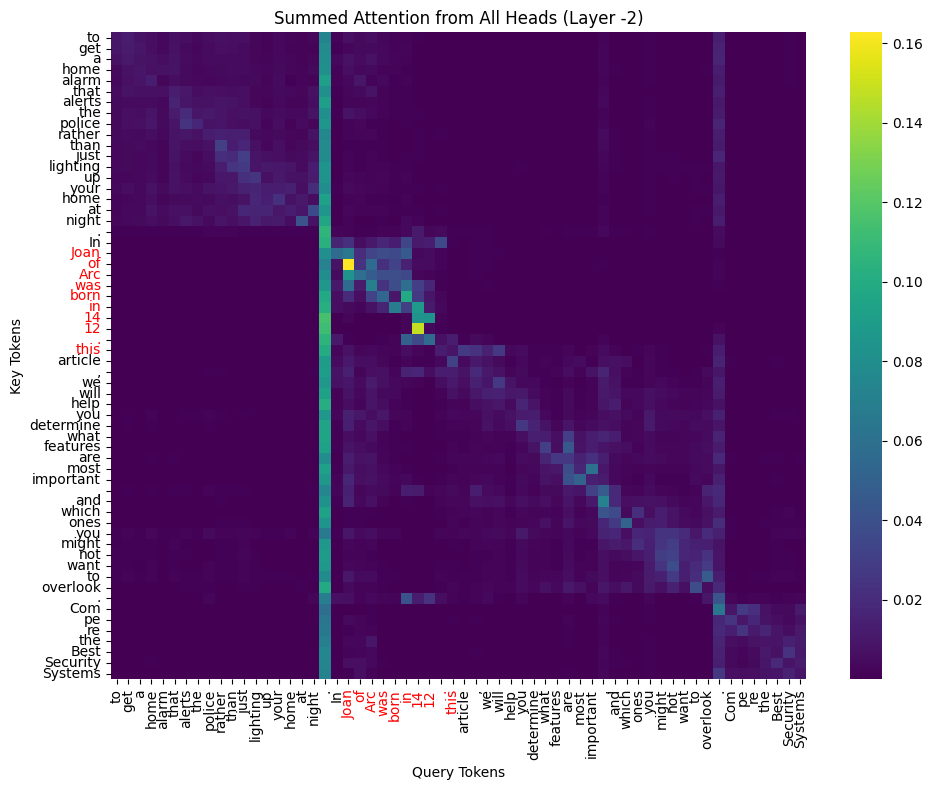

In [ ]:
# Load the model and tokenizer
#from transformers import BigBirdTokenizer, BigBirdForQuestionAnswering

#tokenizer = BigBirdTokenizer.from_pretrained("google/bigbird-base-trivia-itc", attention_type="original_full")
#model = BigBirdForQuestionAnswering.from_pretrained("google/bigbird-base-trivia-itc")

#model_name = "google/bigbird-base-trivia-itc"
model_name = 'deepset/roberta-base-squad2'

model = AutoModelForQuestionAnswering.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

haystack = """If you are considering a home security system, there are a few features that you need to take into consideration before buying a Ft. Smith Arkansas Home Security System. First of all, is the type of alarm system that you need. There are many different kinds available, so you want to choose one that best suits your needs and your home’s security requirements. For example, if you live alone or with small children, you will want to get a home alarm that alerts the police rather than just lighting up your home at night. In this article, we will help you determine what features are most important, and which ones you might not want to overlook.

Compere the Best Security Systems

Best ways to protect your home.


“There are many different ways to protect your home, but one of the best ways is a home security system. It’s important to note that this system isn’t just for older people who live alone. Even if you only have one alarm, or just a spare key, you can protect your home with the help of a home security system. Here are some of the best ways to protect your home with the help of a home security system.

When most people think of a home security system, they think of having a monitored alarm system. This is usually where you get burglar alarms installed. While this is definitely one of the best ways to protect your home, there are other types out there. One such alternative is a do-it-yourself home security system. It may not be as effective as a monitored system, but it can be just as reassuring if you’re going to be away from home for an extended period of time. Many homeowners go this route because it’s inexpensive and does not take much expertise to install.

If you don’t have a lot of money, you can go the cheap route and install wireless security cameras. These cameras can either be hooked up to a DVR, or recorded to a VCR tape. If you’re really worried about your home being protected, then opt for the latter. The recorded tapes can then be played at night, and are sure to wake the neighbors up! However, wireless cameras can also be an excellent way to keep an eye on your pets if you’re not home a lot.

The best ways to protect your home and your family from home invaders and burglars are to make your home as off-limits as possible. Unwind at home, watch a movie, go out with friends, avoid heavy traffic, and get away from the noise of the neighborhood. When you leave the house, close all of the doors and windows, and lock them so that no one can get in. This sounds pretty basic, but it’s incredibly effective at keeping thieves out, since they have nothing to steal from you while you’re not home.
"""

needle = "Joan of Arc was born in 1412."

question = "What was Joan of Arc born?"

new_question, new_context, needle_token_index, needle_length = create_inputs(tokenizer, question, haystack, needle, 256, 0.5, False)

print(new_context)
print(new_question)

# Extract attention weights
attentions, input_ids, predicted_answer = extract_attention_weights(model, tokenizer, new_question, new_context)

print(predicted_answer)



# Visualize attention for the selected layer and head
visualize_attention(attentions, input_ids, tokenizer, layer_idx, needle_token_index, needle_length, True)

# Test Context Lengths

In [ ]:

cont_lens = [64, 128, 256, 512]

# List to store valid articles
haystacks = []

# Keep picking until we have 10 articles with at least 500 words
while len(haystacks) < 15:
    # Pick a random article
    random_idx = random.randint(0, len(df) - 1)
    article_text = df.iloc[random_idx]['text']

    # Count words
    word_count = len(article_text.split())

    # Add to list if it meets the word requirement
    if word_count >= 500:
        haystacks.append(article_text)

# Path to your text file
file_path = "/content/needles.txt"

# Read and split the content into blocks (separated by blank lines)
with open(file_path, "r") as f:
    content = f.read().strip()

# Split into chunks using double newlines
blocks = content.split("\n\n")

# Extract needle, question, and expected answer from each block
triples = []
i=0
for block in blocks:

    lines = block.strip().splitlines()
    if len(lines) == 3:
        needle, question, expected_answer = lines

        haystack = haystacks[i]
        i+=1

        for context_length in cont_lens:

          new_question, new_context, needle_token_index, needle_length = create_inputs(tokenizer, question, haystack, needle, context_length, 0.5, False)

          print("\n\n LENGTH = " + str(context_length))
          print("\n📌 Context with needle inserted:")
          print(new_context)

          print("\n❓ Question:")
          print(new_question)

          # Extract attention weights
          attentions, input_ids, predicted_answer = extract_attention_weights(model, tokenizer, new_question, new_context)

          print("\n🧠 Model's predicted answer:")
          print(predicted_answer)

          # Choose a layer and head to visualize (can adjust based on which layer and head you want)
          layer_idx = -1  # Example: last layer

          # Visualize attention
          for layer_id in range(len(attentions)):
            print(f"\n🎯 Visualizing Sum of Attention Heads from Layer {layer_id} (around needle)...")
            visualize_attention(attentions, input_ids, tokenizer, layer_id, needle_token_index, needle_length, True)




# Test Insertion Depths

In [ ]:
# Load the model and tokenizer
#model_name = "deepset/roberta-base-squad2"
#model = AutoModelForQuestionAnswering.from_pretrained(model_name, output_attentions=True)
#tokenizer = AutoTokenizer.from_pretrained(model_name)

depths = [0.25,0.5,0.75]

# List to store valid articles
haystacks = []

# Keep picking until we have 10 articles with at least 500 words
while len(haystacks) < 15:
    # Pick a random article
    random_idx = random.randint(0, len(df) - 1)
    article_text = df.iloc[random_idx]['text']

    # Count words
    word_count = len(article_text.split())

    # Add to list if it meets the word requirement
    if word_count >= 500:
        haystacks.append(article_text)

# Path to your text file
file_path = "/content/needles.txt"

# Read and split the content into blocks (separated by blank lines)
with open(file_path, "r") as f:
    content = f.read().strip()

# Split into chunks using double newlines
blocks = content.split("\n\n")

# Extract needle, question, and expected answer from each block
triples = []
i=0
for block in blocks:

    lines = block.strip().splitlines()
    if len(lines) == 3:
        needle, question, expected_answer = lines

        haystack = haystacks[i]
        i+=1

        for depth in depths:

          new_question, new_context, needle_token_index, needle_length = create_inputs(tokenizer, question, haystack, needle, 256, depth, False)

          print("\n\n DEPTH = " + str(depth))
          print("\n📌 Context with needle inserted:")
          print(new_context)

          print("\n❓ Question:")
          print(new_question)

          # Extract attention weights
          attentions, input_ids, predicted_answer = extract_attention_weights(model, tokenizer, new_question, new_context)

          print("\n🧠 Model's predicted answer:")
          print(predicted_answer)

          #P, R, F1 = score([predicted_answer], [expected_answer], lang="en", verbose=False)

          #print(f"\n📈 F1 Score: {F1.item():.4f}")

          # Choose a layer and head to visualize (can adjust based on which layer and head you want)
          layer_idx = -1  # Example: last layer

          # Visualize attention for the selected layer and head
          print(f"\n🎯 Visualizing attention from Layer {layer_idx} Head {head_idx} (around needle)...")
          visualize_attention(attentions, input_ids, tokenizer, layer_idx, needle_token_index, needle_length, False)



In [ ]:
pip install datasets transformers flash_attention accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/booydar/babilong source

Cloning into 'source'...
remote: Enumerating objects: 2962, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 2962 (delta 43), reused 46 (delta 38), pack-reused 2890 (from 1)
Receiving objects: 100% (2962/2962), 42.71 MiB | 10.66 MiB/s, done.
Resolving deltas: 100% (2199/2199), done.


In [ ]:
import torch
import datasets
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline

from tqdm.auto import tqdm
import pandas as pd
import json

from pathlib import Path

from source.babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from source.babilong.babilong_utils import compare_answers

In [ ]:
# data split with 0k tokens
data_0k = datasets.load_dataset("RMT-team/babilong", '0k')

needle_length = 100

for i in range(needle_length):
    for value in data_0k['qa2'][i].values():
        print(value)
    print()

Mary journeyed to the bathroom. Sandra went to the garden. Daniel went back to the garden. Daniel went to the office. Sandra grabbed the milk there. Sandra put down the milk there. Daniel went to the hallway. Sandra got the milk there. Daniel went to the garden. Daniel journeyed to the kitchen. Daniel journeyed to the bedroom. Mary journeyed to the garden. Daniel took the football there. Mary moved to the office. Sandra travelled to the bedroom. Daniel dropped the football. Sandra left the milk there. Daniel grabbed the football there. Sandra grabbed the milk there. Daniel went to the kitchen.
Where is the football? 
kitchen

Daniel journeyed to the office. John took the football there. John discarded the football. John travelled to the garden. Daniel travelled to the garden. Sandra went to the garden. Daniel travelled to the kitchen. Daniel moved to the office. Mary grabbed the milk there. Daniel journeyed to the bedroom. John travelled to the office. Daniel travelled to the bathroom.

In [ ]:
import string

def isCorrect(output, target):

  output = output.strip().lower()
  target = target.strip().lower()

  if target not in (output):
    return False

  leeway = 6

  return abs(len(output.split(" ")) - len(target.split(" "))) <= leeway

In [ ]:
test_set = "needles_q2"
split_needle = False

In [ ]:


# List to store valid articles
haystacks = []

# Keep picking until we have 10 articles with at least 500 words
while len(haystacks) < 100:
    # Pick a random article
    random_idx = random.randint(0, len(df) - 1)
    article_text = df.iloc[random_idx]['text']

    # Count words
    word_count = len(article_text.split())

    # Add to list if it meets the word requirement
    if word_count >= 500:
        haystacks.append(article_text)

    #haystacks.append("")

# Path to your text file
file_path = "/content/" + test_set + ".txt"

# Read and split the content into blocks (separated by blank lines)
with open(file_path, "r") as f:
    content = f.read().strip()

# Split into chunks using double newlines
needles = content.split("\n\n")

# Extract needle, question, and expected answer from each block
triples = []
i=0
accuracy = 0
for example in needles:

    lines = example.strip().splitlines()
    if len(lines) == 3:
        needle, question, expected_answer = lines

        haystack = haystacks[i]
        i+=1

        new_question, new_context, needle_token_index, needle_length = create_inputs(tokenizer, question, haystack, needle, 512, 0.5, split_needle)

        print("\n\n ========================= LENGTH = " + str(len(new_context)) + "===========================")
        print("\n📌 Context with needle inserted:")
        print(new_context)

        print("\n❓ Question:")
        print(new_question)

        # Extract attention weights
        attentions, input_ids, predicted_answer = extract_attention_weights(model, tokenizer, new_question, new_context)

        print("\n🧠 Model's predicted answer:")
        print(predicted_answer)

        print("\n🎯 Expected answer:")
        print(expected_answer)

        #P, R, F1 = score([predicted_answer], [expected_answer], lang="en", verbose=False)

        correct = isCorrect(predicted_answer, expected_answer)
        if(correct):
          accuracy+=1

        print("\n Answer was:")
        print("✅ correct" if correct else "❌ incorrect")

        # Choose a layer and head to visualize (can adjust based on which layer and head you want)
        layer_idx = -1  # Example: last layer

        # Visualize attention for the selected layer and head
        print(f"\n🔎 Visualizing attention from Layer {layer_idx} Head {head_idx} (around needle)...")
        visualize_attention(attentions, input_ids, tokenizer, layer_idx, needle_token_index, needle_length, True)

print("\n📈 Accuracy = :")
print(str(accuracy) + "/" + str(len(needles)))



Printing out the accuracy results of Roberta with Babilong needles

In [ ]:
#figure(
  grid(
    columns: 2,
    gutter: 2mm,
    image("split_1.png"),
    image("split_2.png")
  ),
  caption: "Split Comparison"
)s
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import os

import pandas as pd
import numpy as np
import re

In [ ]:
model_name = 'deepset/roberta-base-squad2'

tasks = ['qa1', 'qa2']
lengths = ['no_context', 'with_context', 'context_split_needle']
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'/content/{task}_{ctx_length}.txt'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue

        with open(fname, 'r') as file:
          text_content = file.read()


        # Use regular expression to find the accuracy pattern
        match = re.search(r"Accuracy = :\s*(\d+)/100", text_content)

        if match:
            # Extract the captured group (the accuracy number)
            accuracy[j, i] = int(match.group(1))

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(7.5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Performance of {model_name} \n on BABILong Needles \n')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()